### **Struktura projektu**
* **data structures** - implementacja klas BusStop oraz Connection - klasy tworzące graf połączeń wraz z metodą konstruujuącą graf z pliku .csv
* **shortest_path.py**
* **tsa_solver**
* **utils**


In [1]:
from src.data_structures import *  
from src.utils import *           
from src.shortest_path import *     
from src.tsa_solver import *       



import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple
from datetime import datetime
import pickle

### **Źródło danych** 
Dane zostały pobrane ze strony miasta Wrocław i zapisane w pliku **mpk_data.csv**.  

W zbiorze danych występują przystanki, które mają identyczne nazwy, ale różnią się położeniem geograficznym.  

W dalszej części takie przystanki zostaną:  
- wykryte na podstawie współrzędnych geograficznych oraz nazwy,  
- odpowiednio zaindeksowane

In [ ]:
df = pd.read_csv("mpk_data.csv")
datetime_format = "%H:%M:%S"
df_unique = df[[ 'start_stop' , 'start_stop_lat', 'start_stop_lon']].drop_duplicates()
df_unique['start_stop_index'] = df_unique.index + 1
df = df.drop(columns=['start_stop_index'], errors='ignore')

df = df.merge( df_unique[['start_stop' , 'start_stop_lat', 'start_stop_lon', 'start_stop_index']],
    on=['start_stop' , 'start_stop_lat', 'start_stop_lon'],
    how='left'
)

df.to_csv('mpk_indexed.csv')
graph = load_csv_data('mpk_indexed.csv')
with open('mpk_graph.pickle', 'wb') as f:
    pickle.dump(graph, f)

In [2]:
with open('mpk_graph.pickle', 'rb') as f:
    graph = pickle.load(f)

route_planer = RoutePlaner(graph)

### **Opis teoretyczny algorytmów**  

#### **Algorytm Dijkstry**  
Algorytm Dijkstry to klasyczna metoda wyszukiwania najkrótszej ścieżki w grafie o dodatnich wagach krawędzi. Działa na zasadzie eksploracji wierzchołków w kolejności rosnących kosztów dojścia, zapewniając optymalne rozwiązanie.  

**Kroki działania:**  
- **Inicjalizacja** – każdemu wierzchołkowi przypisywana jest wartość odległości: `0` dla wierzchołka startowego i `∞` dla pozostałych.  
- **Kolejka priorytetowa** – wierzchołki są przetwarzane w kolejności od najmniejszej znanej wartości kosztu dojścia.  
- **Relaksacja krawędzi** – dla każdego sąsiada aktualnego wierzchołka sprawdzana jest możliwość poprawienia jego kosztu dojścia.  
- **Aktualizacja kolejki** – jeśli koszt dojścia do wierzchołka ulegnie zmianie, jest on ponownie umieszczany w kolejce priorytetowej.  
- **Zakończenie** – algorytm kończy działanie, gdy wierzchołek docelowy zostanie przetworzony lub kolejka priorytetowa stanie się pusta.  

#### **Algorytm A\***  
jest ulepszeniem algorytmu Dijkstry, wykorzystujące heurystykę – funkcję szacującą koszt dotarcia do celu. Dzięki temu możliwe jest ograniczenie liczby przeszukiwanych wierzchołków i przyspieszenie działania algorytmu.  

W algorytmie A\* każdemu wierzchołkowi przypisywana jest wartość funkcji kosztu:  

*f(n) = g(n) + h(n)*

gdzie:  
- *g(n)* – rzeczywisty koszt dojścia do węzła n,  
- *h(n)* – estymacja kosztu dojścia z n do celu (heurystyka).  

**Działanie algorytmu:**  
Kolejka priorytetowa w A\* obsługuje dodatkowo szacunkową wartość dotarcia do celu, co pozwala na:  
- ograniczenie eksploracji grafu,  
- zmniejszenie wartości funkcji kosztu,  
- redukcję wykorzystania zasobów obliczeniowych.  

Efektywność algorytmu A\* w dużej mierze zależy od jakości dobranej heurystyki. Przy odpowiednio dopasowanej funkcji *h(n)*, algorytm może działać w czasie bliskim liniowemu.

### **Cel**
Celem było opracowanie algorytmu wyszukiwania optymalnych połączeń między przystankami z wykorzystaniem algorytmów Dijkstry i A*.
Algorytm A* sprowadza się do algorytmu Dijkstry w przypadku gdy funckja heurystyczna zawsze zwraca 0.  W efekcie eksploracja grafu odbywa się równomiernie, bez preferencji kierunkowych, a wybór trasy opiera się wyłącznie na rzeczywistym czasie przejazdu.

### **Wybrane heurystki**

- **Heurystyka euklidesowa** - wyznacza odległość między przystankiem następnym a docelowym, przeliczając dystans na czas przejazdu na podstawie średniej prędkości autobusu. Wynik jest skalowany przez stały współczynnik dostosowany eksperymentalnie.  

- **Heurystyka kierunkowa** - oblicza kąt między przystankiem obecnym, następnym a docelowym, nakładając karę, gdy zmiana kierunku przekracza 60°. Dzięki temu ogranicza eksplorację do stożka o kącie 120° skierowanego w stronę celu, co pozwala na szybszą konwergencję.

- **Heurystyka haversine** – wykorzystuje rzeczywistą odległość geograficzną między przystankami, a dodatkowo uwzględnia koszt zmiany linii, dodając stałą karę za konieczność oczekiwania na kolejny kurs.

### **Modyfikacje algorytmu A\***

- funkcja `astar_changes` - polega na zmianie sposobu obsługi kolejki piorytetowej. Modyfikacja algorytmu A* w funkcji `astar_changes` polega na zmianie sposobu obsługi kolejki priorytetowej. Oprócz łącznego szacowanego kosztu (suma rzeczywistego czasu przejazdu i wartości heurystyki) algorytm uwzględnia również liczbę przesiadek. Wprowadzona zmiana pozwala preferować trasy, które nie tylko minimalizują czas podróży, ideą algorytmu było wyszukiwanie wygodnych połączeń - z małą liczbą przesiadek w rozsądnym czasie dojazdu.

- funkcja `astar_min_transfers` - celem było skupienie się na całkowitej minimalizacji funkcji kosztu - liczby przesiadek. W takim podejścu, czas dojazdu nie jest brany pod uwagę. Zmiana dotyczy sposobu wybierania połączeń w trakcie odwiedzania nowych węzłów, algorytm priorytetyzuje wybór tej samej linii autobusowej, dodatkowo zmieniona zostaje struktura zbioru zamkniętych węzłów - przechowywana jest tam krotka - (przystanek, linia)


### **Ponizej znajduja sie przykladowe wywolania algorytmow dla danych przystanków**

In [5]:
start_stop = 'Jagodzińska'
end_stop = 'Kochanowskiego'
departure_time = '10:30:00'

### **Algorytm Dijkstry**

In [23]:
totaltime, route, visited_nodes, visited_connections = route_planer.astar(
    start_stop=start_stop, 
    end_stop=end_stop, 
    departure_time=departure_time,
    heuristic_function=route_planer.zero_heuristic
)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections, start_stop_str=start_stop)

Całkowity czas podróży: 34.0 min
Odwiedzone węzły: 216
Odwiedzone połączenia: 701
Początek podróży: Jagodzińska
Koniec podróży: Kochanowskiego
+----+---------+----------+----------+-------------------------+----------------------+
|    | Linia   | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 | 110     | 10:30:00 | 10:42:00 | Jagodzińska             | Hubska (Dawida)      |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 | 16      | 10:47:00 | 11:00:00 | Hubska (Dawida)         | PL. GRUNWALDZKI      |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 | D       | 11:01:00 | 11:04:00 | PL. GRUNWALDZKI         | Kochanowskiego       |
+----+---------+----------+----------+-------------------------+----------------------+


### **Algorytm A\* oparty z heurystyką opartą o szacowany czas przyjazdu na podstawie odległości euklidesowej**


In [19]:

totaltime, route, visited_nodes, visited_connections = route_planer.astar(start_stop=start_stop, 
                                                                          end_stop=end_stop, 
                                                                          departure_time=departure_time,
                                                                          heuristic_function=route_planer.euclidean_distance_heuristic)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections, start_stop_str=start_stop)

Całkowity czas podróży: 35.0 min
Odwiedzone węzły: 78
Odwiedzone połączenia: 278
Początek podróży: Jagodzińska
Koniec podróży: Kochanowskiego
+----+---------+----------+----------+-------------------------+----------------------+
|    |   Linia | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 |     110 | 10:30:00 | 10:35:00 | Jagodzińska             | Morwowa              |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 |     100 | 10:39:00 | 10:40:00 | Morwowa                 | Złotostocka          |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 |     143 | 10:44:00 | 10:57:00 | Złotostocka             | 8 Maja               |
+----+---------+----------+----------+-------------------------+----------------------+
|  3 |       9 | 11:00:00 | 11:05:00 | 8 Maja                  | K

### **Algorytm A\* oparty z heurystyką opartą o szacowany czas przyjazdu na podstawie odległości haversine i zmianach linii**


In [6]:
totaltime, route, visited_nodes, visited_connections = route_planer.astar(start_stop=start_stop, 
                                                                          end_stop=end_stop, 
                                                                          departure_time=departure_time,
                                                                          heuristic_function=route_planer.haversine_distance_heuristic)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections, start_stop_str=start_stop)

Całkowity czas podróży: 50.0 min
Odwiedzone węzły: 266
Odwiedzone połączenia: 828
Początek podróży: Jagodzińska
Koniec podróży: Kochanowskiego
+----+---------+----------+----------+-------------------------+----------------------+
|    |   Linia | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 |     110 | 10:30:00 | 10:35:00 | Jagodzińska             | Morwowa              |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 |     100 | 10:39:00 | 10:44:00 | Morwowa                 | Karwińska            |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 |       5 | 10:46:00 | 10:48:00 | Karwińska               | Armii Krajowej       |
+----+---------+----------+----------+-------------------------+----------------------+
|  3 |     143 | 11:05:00 | 11:14:00 | Armii Krajowej          | 

### **Algorytm A\* oparty z heurystyką opartą o szacowany czas przyjazdu na podstawie kąta i zmianach linii**


In [25]:

totaltime, route, visited_nodes, visited_connections = route_planer.astar(start_stop=start_stop, 
                                                                          end_stop=end_stop, 
                                                                          departure_time=departure_time,
                                                                          heuristic_function=route_planer.angle_between_heuristic)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections, start_stop_str=start_stop)

Całkowity czas podróży: 34.0 min
Odwiedzone węzły: 64
Odwiedzone połączenia: 229
Początek podróży: Jagodzińska
Koniec podróży: Kochanowskiego
+----+---------+----------+----------+-------------------------+----------------------+
|    | Linia   | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 | 110     | 10:30:00 | 10:42:00 | Jagodzińska             | Hubska (Dawida)      |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 | 16      | 10:47:00 | 11:00:00 | Hubska (Dawida)         | PL. GRUNWALDZKI      |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 | D       | 11:01:00 | 11:04:00 | PL. GRUNWALDZKI         | Kochanowskiego       |
+----+---------+----------+----------+-------------------------+----------------------+


### **Algorytm A\* oparty z heurystyką opartą na odległości haversine i liczbie zmian linii w kolejce piorytetowej**

In [ ]:
totaltime, route, visited_nodes, visited_connections = route_planer.astar_changes(start_stop=start_stop, 
                                                                          end_stop=end_stop, 
                                                                          departure_time=departure_time)
display_results(route=route, totaltime=totaltime, visited_nodes=visited_nodes, visited_connections=visited_connections, start_stop_str=start_stop)

Całkowity czas podróży: 134.0 min
Odwiedzone węzły: 91
Odwiedzone połączenia: 212
Początek podróży: Jagodzińska
Koniec podróży: Kochanowskiego
+----+---------+----------+----------+-------------------------+----------------------+
|    | Linia   | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 | 110     | 10:30:00 | 10:53:00 | Jagodzińska             | GALERIA DOMINIKAŃSKA |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 | D       | 10:55:00 | 11:04:00 | GALERIA DOMINIKAŃSKA    | Kochanowskiego       |
+----+---------+----------+----------+-------------------------+----------------------+


### **Algorytm A\* minimalizujący liczbę przesiadek**

#### **Porównanie wyników algorytmów `astar_min_transfers` i `astar_changes`**  

Poniżej przedstawiono porównanie wyników działania algorytmów `astar_min_transfers` oraz `astar_changes` dla identycznych danych wejściowych.  

- **`astar_min_transfers`** – algorytm ten znalazł połączenie z minimalną liczbą przesiadek, ograniczając je do zaledwie dwóch. Jednak aby osiągnąć ten cel, konieczne było aż **10 godzin oczekiwania** na przesiadkę. Mimo że rozwiązanie to jest zgodne z założeniem minimalizacji liczby przesiadek, w praktyce nie jest ono korzystne pod względem całkowitego czasu podróży.  

- **`astar_changes`** – ten wariant algorytmu również uwzględnia liczbę przesiadek w funkcji heurystycznej i kolejce priorytetowej, ale dodatkowo bierze pod uwagę **szacowany czas dotarcia do celu**. Dzięki temu unika długiego oczekiwania na przesiadkę i zamiast tego wybiera trasę, która pozwala dotrzeć do celu w **niecałe 4 godziny**. W przedstawionym przypadku rozwiązanie to było optymalne – choć trasa prowadziła przez cały Wrocław liniami podmiejskimi, czas podróży był znacznie krótszy niż w przypadku `astar_min_transfers`.

In [3]:
_, route, visited_nodes, visited_connections = route_planer.astar_min_transfers(start_stop="Klęka", 
                                                                          end_stop="Kątna", 
                                                                          departure_time="12:00:00")
display_results(route=route, totaltime=None, visited_nodes=visited_nodes, visited_connections=visited_connections, start_stop_str="Klęka")

+----+---------+----------+----------+-------------------------+----------------------+
|    |   Linia | Start    | Koniec   | Przystanek początkowy   | Przystanek końcowy   |
+====+=========+==========+==========+=========================+======================+
|  0 |     958 | 13:07:00 | 13:42:00 | Klęka                   | LEŚNICA              |
+----+---------+----------+----------+-------------------------+----------------------+
|  1 |     253 | 23:42:00 | 04:34:00 | LEŚNICA                 | Kwidzyńska           |
+----+---------+----------+----------+-------------------------+----------------------+
|  2 |     921 | 05:58:00 | 06:34:00 | Kwidzyńska              | Kątna                |
+----+---------+----------+----------+-------------------------+----------------------+


In [4]:
_, route, visited_nodes, visited_connections = route_planer.astar_changes(start_stop="Klęka", 
                                                                          end_stop="Kątna", 
                                                                          departure_time="12:00:00")
display_results(route=route, totaltime=None, visited_nodes=visited_nodes, visited_connections=visited_connections, start_stop_str="Klęka")

+----+---------+----------+----------+---------------------------------+---------------------------------+
|    |   Linia | Start    | Koniec   | Przystanek początkowy           | Przystanek końcowy              |
+====+=========+==========+==========+=================================+=================================+
|  0 |     958 | 13:07:00 | 13:42:00 | Klęka                           | LEŚNICA                         |
+----+---------+----------+----------+---------------------------------+---------------------------------+
|  1 |      10 | 13:44:00 | 14:31:00 | LEŚNICA                         | PL. GRUNWALDZKI                 |
+----+---------+----------+----------+---------------------------------+---------------------------------+
|  2 |     911 | 14:33:00 | 15:03:00 | PL. GRUNWALDZKI                 | Kiełczów - Zgodna               |
+----+---------+----------+----------+---------------------------------+---------------------------------+
|  3 |     931 | 15:09:00 | 15:18:00 

### **Wyniki algorytmów**

| Heuristic            | Visited Connections | Number of Transfers | Total Time  |
|----------------------|--------------------|---------------------|------------|
| Angle Between       | 481.037383         | 2.831776            | 75.744444  |
| Euclidean Distance  | 687.515439         | 3.745843            | 105.517857 |
| Haversine Changes   | 468.198630         | 1.917808            | 274.576642 |
| Haversine Distance  | 755.247191         | 4.196629            | 90.848921  |
| Zero Heuristic      | 1243.934579        | 3.345794            | 74.515306  |


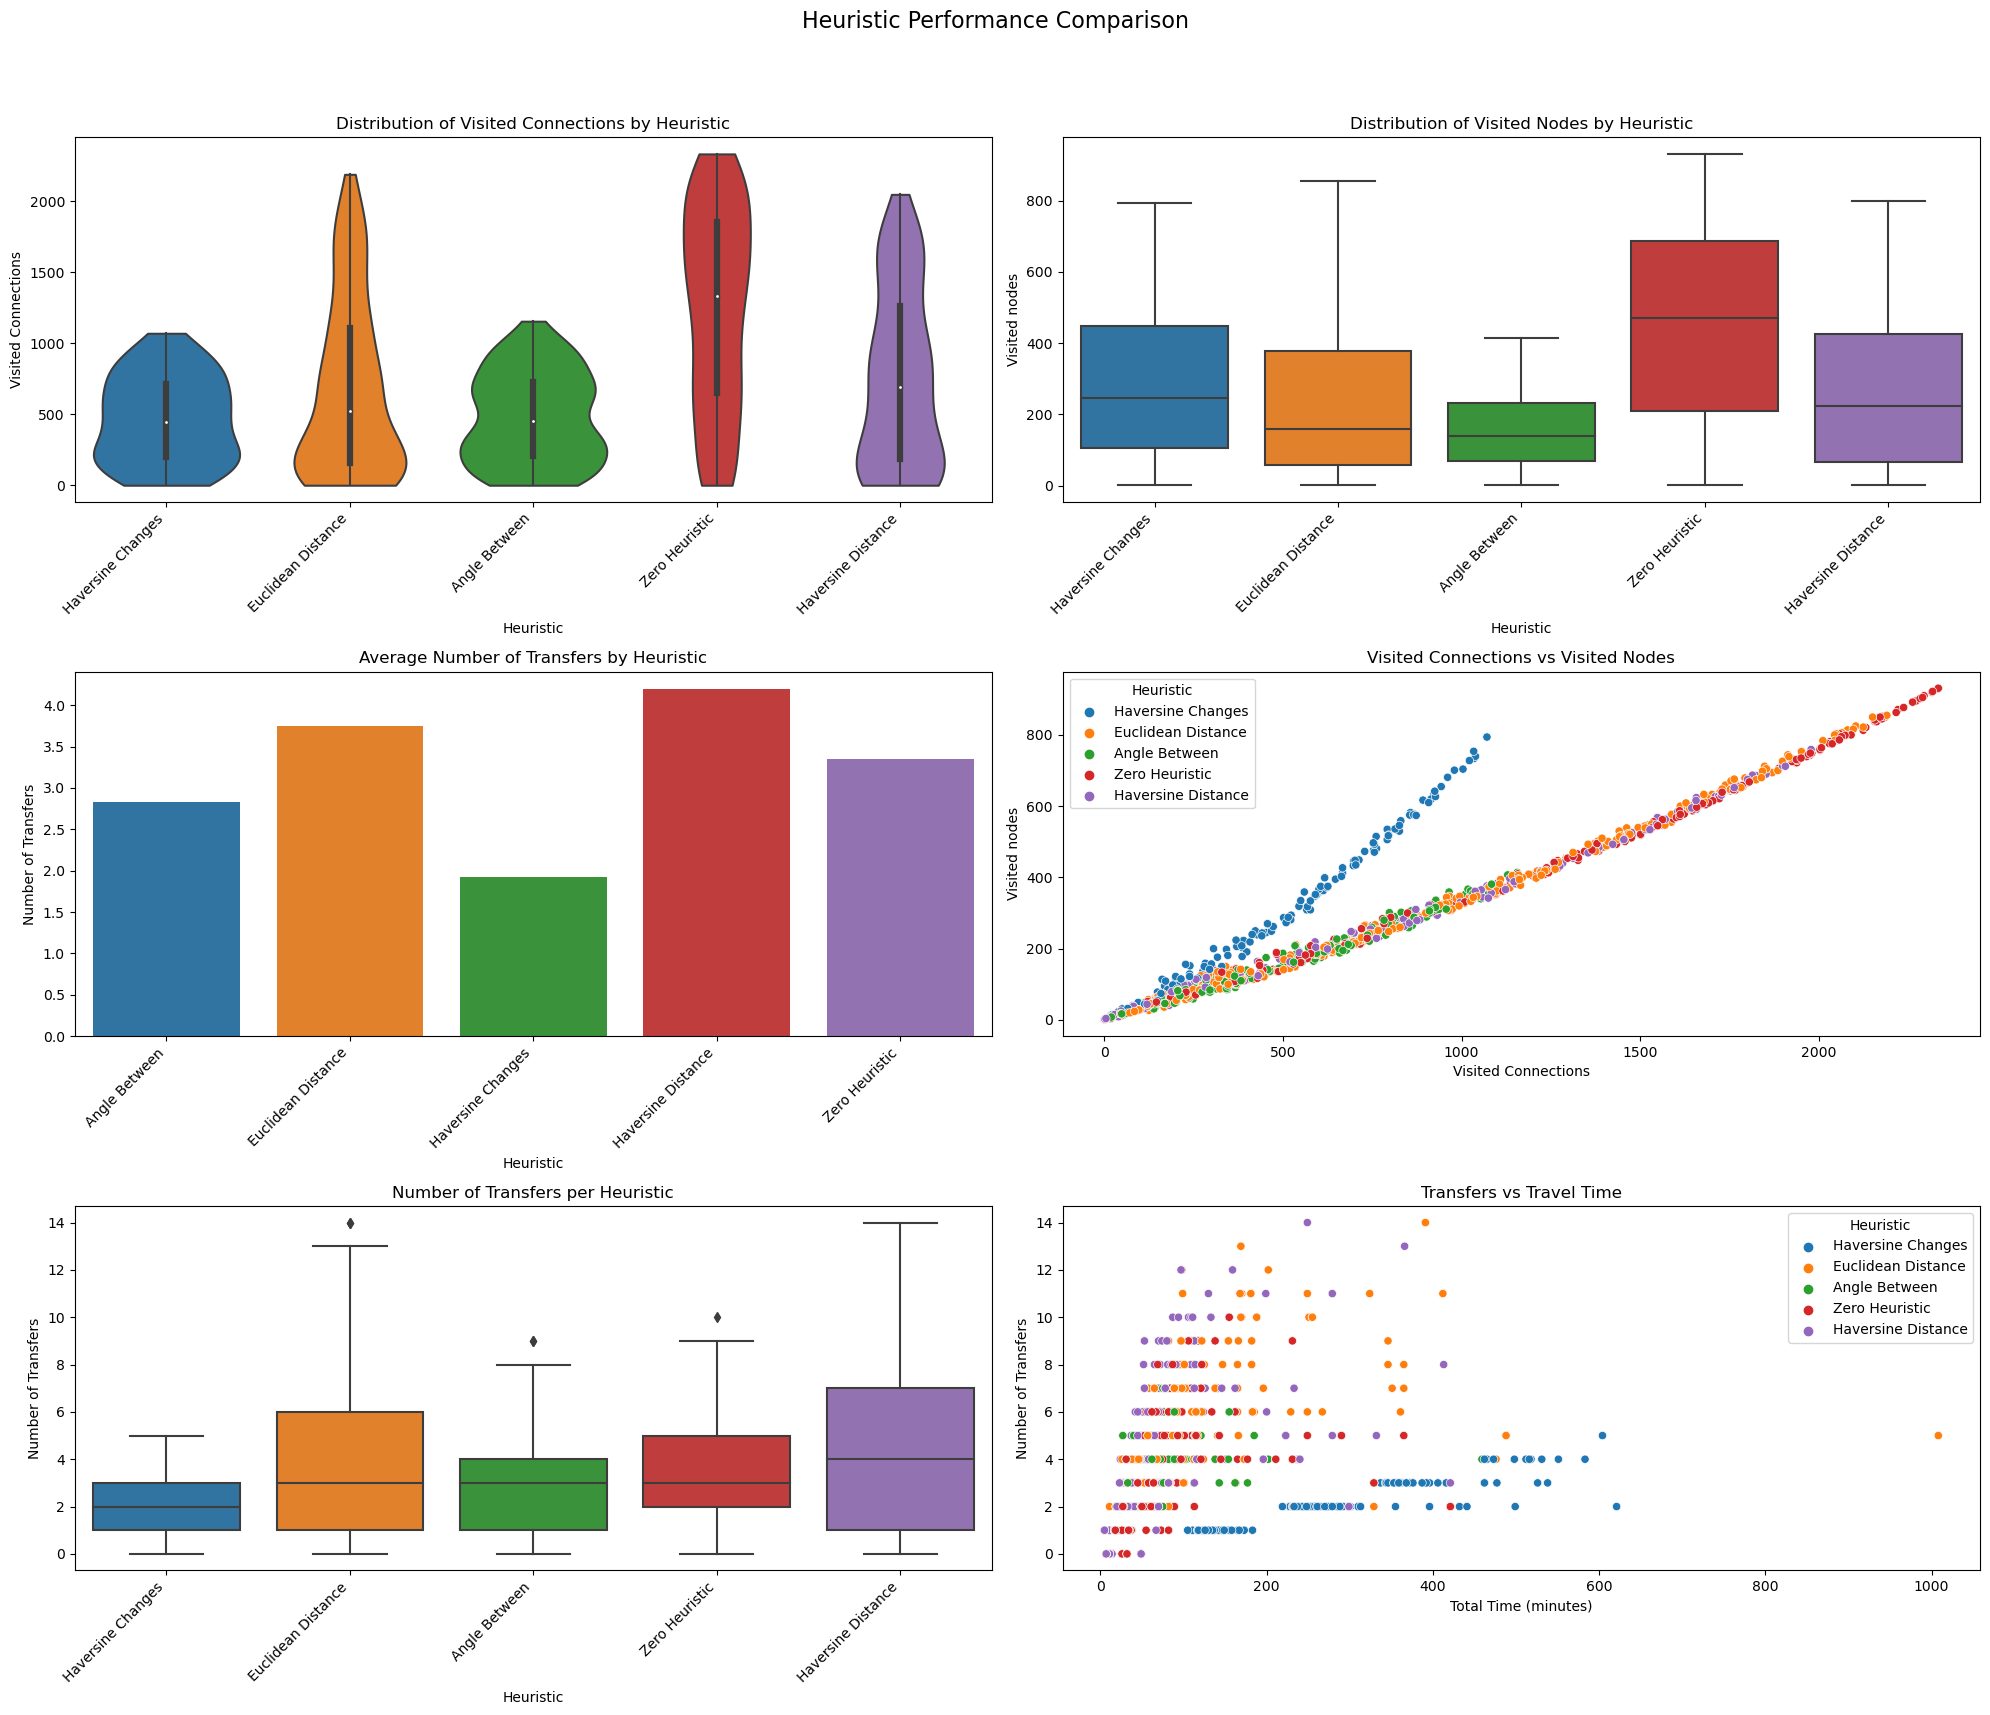

### **Analiza wyników eksperymentu**  

Wyniki testów zostały uzyskane na podstawie 200 losowo wybranych połączeń. Każda z heurystyk wpływała na sposób eksploracji grafu oraz znajdowanie optymalnej ścieżki. Celem analizy jest porównanie ich skuteczności pod względem liczby odwiedzonych wierzchołków i krawędzi, liczby przesiadek oraz całkowitego czasu podróży.  

### **Liczba odwiedzonych krawędzi i wierzchołków**  

Heurystyka oparta na kącie (**Angle Between**) odwiedza najmniejszą liczbę wierzchołków, a liczba odwiedzonych krawędzi jest porównywalna z algorytmem **`astar_changes`**. Jest to zgodne z założeniami – heurystyka ta miała na celu ukierunkowanie eksploracji grafu w stronę przystanku docelowego poprzez stosowanie kar opartych na zmianie kierunku trasy.  

Początkowo heurystyka ta miała minimalizować liczbę przesiadek, i rzeczywiście uzyskane wyniki wskazują na poprawę względem algorytmu Dijkstry oraz innych heurystyk. Jednak pierwotna konstrukcja kolejki priorytetowej ograniczała możliwość efektywnego wyszukiwania tras o najmniejszej liczbie zmian linii.  

### **Liczba przesiadek**  

Najmniejszą liczbę przesiadek generuje algorytm **`astar_min_transfers`** , który modyfikuje sposób działania zbioru zamkniętego i sposobu wyboru krawędzi w odwiedzanych wierzchołkach. Algorytm skupiając się na liczbie przesiadek będzię ja minimalizował i zwracał najmniejsze mozliwe wartosci - oczywiscie kosztem czasu.  

Drugi algorytm czyli **`astar_changes`**, minimalizuje liczbe przesiadek w mozliwie najkrótszym czasie. Liczba przesiadek jest mniejsza, ale większy jest czas podrózy (choć nie tak znacząco jak w przypadku **`astar_min_transfers`**) 

### **Czas podróży**  

Heurystyki oparte na szacowaniu średniego czasu dotarcia do celu (i **Haversine Distance**) nie osiągają idealnych wyników. **Euclidean Distance** radzi sobie w tej kwestii lepiej - czas jest zblizony do wynikow algorytmu Dijkstry.
Zdecydowanie gorzej radzi sobie **Euclidean Distance**. Zapewnie wynika to z faktu, że proste modele odległości nie są wystarczająco dokładne w kontekście transportu publicznego. Kręte trasy autobusowe oraz zmienna prędkość pojazdów powodują, że rzeczywisty czas podróży może znacznie odbiegać od szacunków opartych na średnich wartościach.  

Zastosowanie stałej średniej prędkości dla wszystkich linii autobusowych to znaczne uproszczenie. W rzeczywistości różne linie mogą mieć zupełnie inne charakterystyki – np. linie ekspresowe poruszają się szybciej niż linie miejskie zatrzymujące się na każdym przystanku. Aby poprawić skuteczność heurystyki szacującej czas podróży, należałoby uwzględnić dodatkowe informacje, takie jak dane historyczne o prędkościach na poszczególnych odcinkach trasy.  

Mimo to, najlepsze wyniki w tej kategorii osiągają **algorytm Dijkstry oraz heurystyka Angle Between**, uzyskując bardzo zbliżone wartości całkowitego czasu podróży. Warto jednak zaznaczyć, że algorytm Dijkstry charakteryzuje się znacznie większą złożonością obliczeniową.  

### **Wizualizacja wyników**  

Dobrą ilustracją podziału algorytmów na dwie grupy – te optymalizujące liczbę przesiadek oraz te minimalizujące czas podróży – jest wykres **Visited Connections vs Visited Nodes**.  

Trzy heurystyki (**Euclidean Distance, Haversine Distance, Angle Between**) wykazują niemal liniową zależność między liczbą odwiedzonych wierzchołków a liczbą odwiedzonych krawędzi. Natomiast **Haversine Changes** wyraźnie się wyróżnia, minimalizując liczbę przesiadek.  

Dla tej samej liczby odwiedzonych wierzchołków algorytm **Haversine Changes** analizuje znacznie mniejszą liczbę krawędzi niż heurystyki optymalizujące czas podróży. Oznacza to, że algorytm ten **ignoruje część połączeń, które wymagałyby zmiany linii**, co dobrze oddaje jego działanie i skuteczność w ograniczaniu liczby przesiadek.  

### **Wizualizacja czasu obliczeń algorytmu**
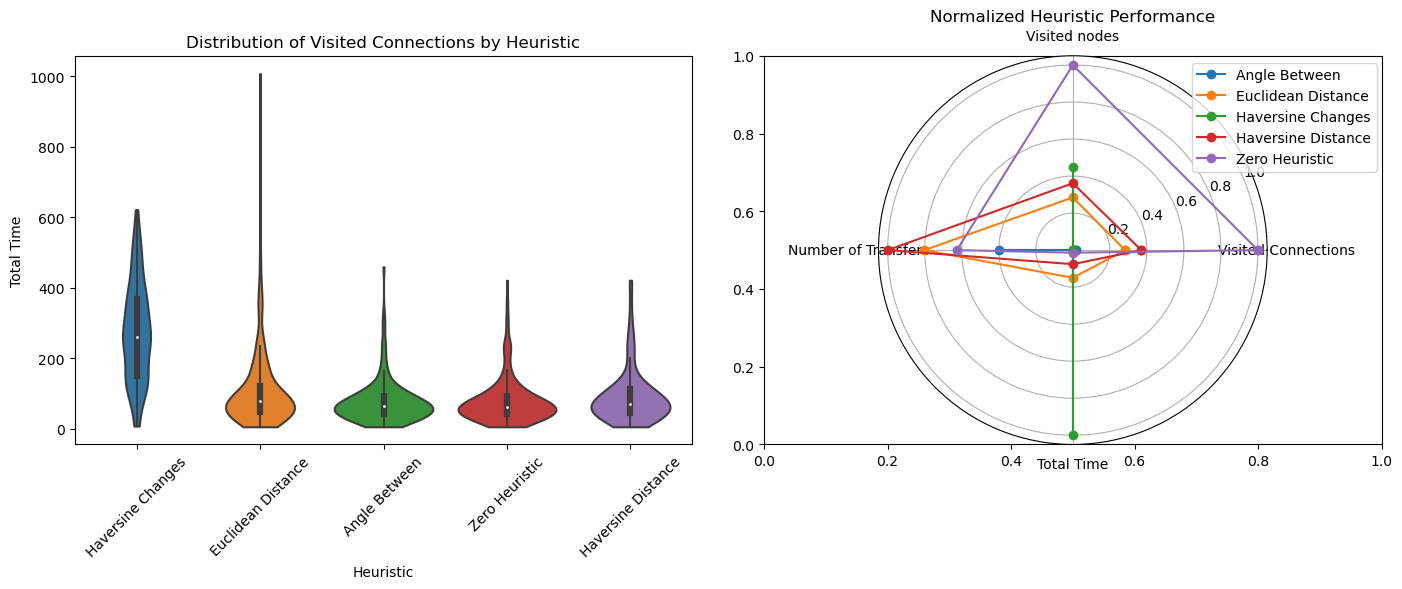

In [3]:
tsa_solver = TSaSolver(graph)

#start_station = "Stalowa"
start_station= "KRZYKI"
#stations_string = "most Grunwaldzki;Kochanowskiego;Wiśniowa;PL. JANA PAWŁA II"
#stations_string = "GRABISZYŃSKA (Cmentarz);ZOO;Urząd Wojewódzki (Muzeum Narodowe);most Grunwaldzki;Kochanowskiego;Wiśniowa;PL. JANA PAWŁA II"
#stations_string = "GRABISZYŃSKA (Cmentarz);Fiołkowa;FAT;Hutmen;Bzowa (Centrum Historii Zajezdnia)"
#stations_string = "Kliniki - Politechnika Wrocławska;BISKUPIN;Stalowa;Krucza;rondo Św. Ojca Pio;most Grunwaldzki;SĘPOLNO"
stations_string = "Tarczyński Arena (Lotnicza);Niedźwiedzia;Bujwida;PARK POŁUDNIOWY;Na Niskich Łąkach;BISKUPIN"

best_solution, best_cost, best_route = tsa_solver.tabu_search(start=start_station, 
                                                              stops=start_station.split(';'), 
                                                              departure_time="12:00:00")

TypeError: unsupported operand type(s) for +=: 'int' and 'NoneType'